In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
from gridworld.environment import WindyGridworld
from tensorflow import keras

## Learning $\pi_b$ from $\mathcal{D} = \{s,a,s',r\}$

In [43]:
def load_dataset_and_trajectories(filename):
    npz = np.load(filename, allow_pickle=True)
    print(npz.files)
    return npz['centroids'], npz['clusters'], npz['trajectories'], npz['rewards'], npz['unique_concepts'], npz['concepts'], npz['actions']

means, clusters, trajectories, rewards, unique_concepts, concepts, actions = load_dataset_and_trajectories("saved_data/dataset_large.npz") #We're using dataset_large and dataset_knn
print(trajectories.shape)
print(rewards.shape)
print(unique_concepts.shape)
print(concepts.shape)
print(actions.shape)
print(means.shape)
print(clusters.shape)


num_concepts = len(means)
env = WindyGridworld(num_concepts=num_concepts, method="simple", knn=None, means=means, policy_model=None, custom_policy=None)

['centroids', 'clusters', 'trajectories', 'rewards', 'unique_concepts', 'concepts', 'actions']
(653,)
(653,)
(653,)
(653,)
(653,)
(5, 2)
(500, 2)


# Data pre-processing

In [6]:
A = env.A

def generate_default_dataset(window_size):
    actions_indexed = actions_to_action_indexes(np.concatenate(actions))
    Y = actions_indexed.reshape(len(actions_indexed), 1)
    # Y = np.concatenate(actions)
    X = np.concatenate(window_states(trajectories, W_s=window_size))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, 4), to_categorical(y_test, 4)

def window_states(trajectories, W_s=30):
    '''Replaces each state with the average value of previous W_s states including the current state, smoothing the trajectories.'''
    windowed_trajectories = []
    for traj in trajectories:
        windowed_traj = np.zeros((len(traj), 2))
        for i in range(1, len(traj)+1):
            window = traj[i - min(W_s, i):i]
            windowed_traj[i-1] = np.sum(window, axis=0)/len(window)
        windowed_trajectories.append(windowed_traj)
    return np.array(windowed_trajectories, dtype='object')

def actions_to_action_indexes(actions):
    '''Returns the index of the action in the state space, e.g. 0 for up, 1 for right etc'''
    indicies = [np.where(np.all((A == a), axis=1))[0][0] for a in actions]
    return np.array(indicies)

## Model

In [45]:
from models.policy import PolicyModel

X_train, X_test, y_train, y_test = generate_default_dataset(window_size=5)
print(X_train.shape)
print(y_train.shape)
pi_b = PolicyModel(input_size=X_train[0].shape, num_actions=4).build()
history = pi_b.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)

(322004, 2)
(322004, 4)
Epoch 1/10
8051/8051 [==============================] - 10s 1ms/step - loss: 1.3041 - categorical_accuracy: 0.3577 - val_loss: 1.3035 - val_categorical_accuracy: 0.3577
Epoch 2/10
8051/8051 [==============================] - 9s 1ms/step - loss: 1.3025 - categorical_accuracy: 0.3567 - val_loss: 1.3033 - val_categorical_accuracy: 0.3520
Epoch 3/10
8051/8051 [==============================] - 9s 1ms/step - loss: 1.3024 - categorical_accuracy: 0.3558 - val_loss: 1.3034 - val_categorical_accuracy: 0.3535
Epoch 4/10
8051/8051 [==============================] - 10s 1ms/step - loss: 1.3023 - categorical_accuracy: 0.3571 - val_loss: 1.3031 - val_categorical_accuracy: 0.3525
Epoch 5/10
8051/8051 [==============================] - 11s 1ms/step - loss: 1.3022 - categorical_accuracy: 0.3581 - val_loss: 1.3033 - val_categorical_accuracy: 0.3533
Epoch 6/10
8051/8051 [==============================] - 10s 1ms/step - loss: 1.3021 - categorical_accuracy: 0.3572 - val_loss: 1.3030

In [8]:
p = np.array([1,-1])
p = p.reshape((1,2))
actions = pi_b.predict(X_test)
print(actions)
predicted_actions = np.argmax(actions, axis=1)
print(predicted_actions[0:200])

[[0.34667793 0.14852081 0.35051438 0.15428686]
 [0.36382174 0.14240907 0.34028253 0.15348667]
 [0.34721848 0.14933592 0.34829143 0.15515418]
 ...
 [0.3423699  0.14860542 0.35212225 0.1569025 ]
 [0.34750205 0.1489298  0.34703007 0.15653805]
 [0.33004493 0.16178446 0.36250478 0.14566587]]
[2 0 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0
 2 2 2 2 2 2 0 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 0 2
 2 2 2 0 2 2 0 2 0 2 0 2 2 2 0 2 2 0 2 2 2 0 2 0 0 2 2 0 2 0 2 0 2 2 2 2 2
 0 0 2 0 2 2 2 2 2 2 2 2 0 2 0 2 2 0 2 2 0 2 0 2 0 0 0 2 2 2 2 2 2 2 0 2 2
 2 0 2 2 2 2 2 2 2 2 0 2 0 0 0 0 2 0 0 0 2 2 2 0 0 2 2 2 2 0 0 2 2 2 2 0 0
 0 0 2 0 2 2 2 2 0 0 2 2 0 0 0]


-3.0
-1.5
0.0
1.5
3.0


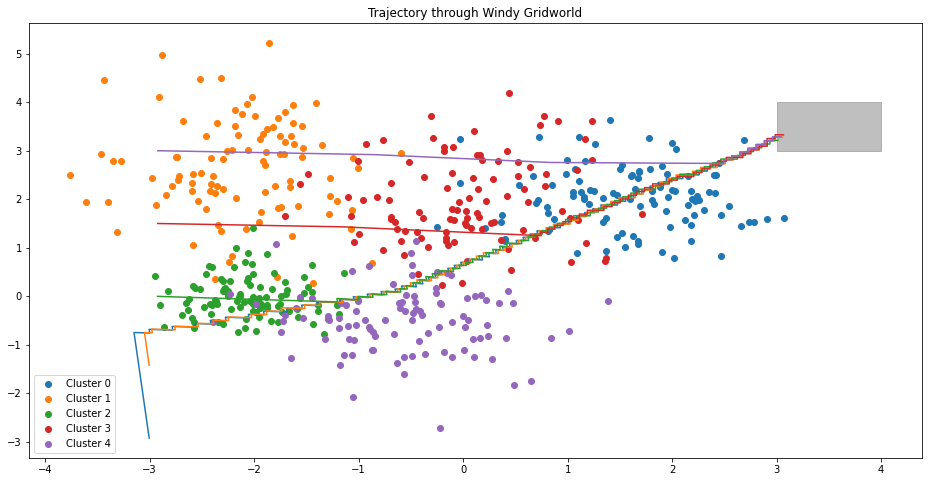

In [46]:
fig, ax2 = plt.subplots(figsize=(16,8))
predicted_actions = []

env.policy_model = pi_b #set policy of agent in the environment

for y in np.linspace(-3,3,5):
    print(y)
    history = env.play(True, [], [], [], [], predicted_actions, s = np.array([-3, y]))
    plt.plot(history[:, 0], history[:, 1])

rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax2.add_patch(rect)

for i in range(num_concepts):
    start = i*100
    end = (i+1)*100
    plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

plt.legend()
plt.title("Trajectory through Windy Gridworld")
plt.show()

## Evaluation Policies $\pi_e(a|c=f(\cdot))$

These can be created in any way but should try achieve the same goal in the environment as the behavioural policy, and should be created with varying degrees of similarity to the behavioural policy.

### $\pi_e(a|c=f(s))$

In [32]:
def policy(s, A, concept_model):
    s = s.reshape((1,2))
    c = np.argmax(concept_model.predict(s)) #predict the concept from the current state
    indices = [0, 1, 2, 3] # up, down, right, left
    p=[0.35, 0.15, 0.35, 0.15] #default distribution of actions
    if c== 1:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==2:
        p=[0.4, 0.1, 0.3, 0.2]
    elif c==3:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==4:
        p=[0.4, 0.1, 0.3, 0.2] #intuitive policy based on concept which is interpretable

    return A[np.random.choice(indices, 1, p=p)[0]]


565


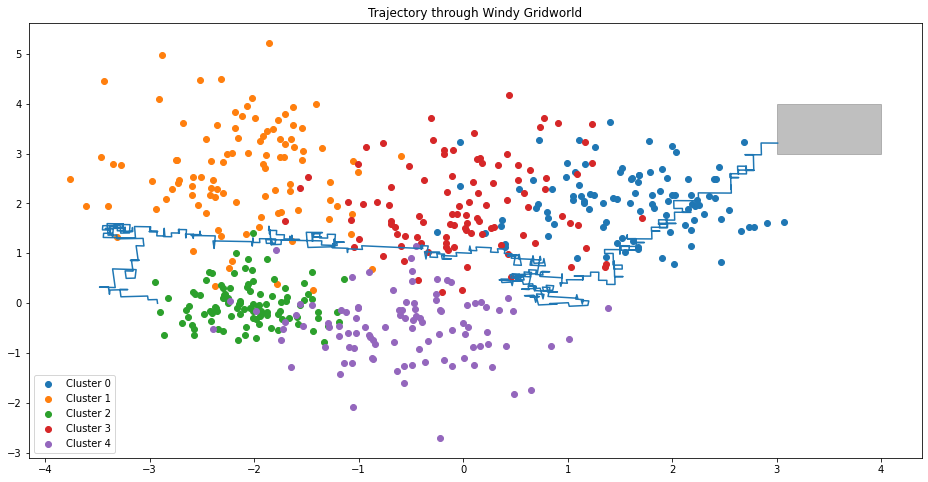

In [39]:
concept_model = keras.models.load_model("saved_models/c|s")
evaluation_env = WindyGridworld(len(means), "simple", None, means, None, policy, concept_model)

history = evaluation_env.play(True, [], [], [], [], [], s = np.array([-3,0]))
print(len(history))
fig, ax3 = plt.subplots(figsize=(16,8))
plt.plot(history[:, 0], history[:, 1])
rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax3.add_patch(rect)

for i in range(len(means)):
    start = i*100
    end = (i+1)*100
    plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

plt.legend()
plt.title("Trajectory through Windy Gridworld")
plt.show()